In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import time
import pickle
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from captum.attr import IntegratedGradients, GuidedBackprop

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from captum.attr import Saliency

import warnings
warnings.filterwarnings('ignore')

import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from lazyvi import LazyVI
from data_generating_funcs import generate_linear_data, MNISTDataModule
from networks import NN4vi, UltraLiteMNIST
from data_generating_funcs import FlexDataModule
from networks import BinClass
from utils import *

In [2]:
def dropout_chunk(X, ix):
    X = np.array(X)
    N = X.shape[0]
    X_change = np.copy(X)
    X_change[:, ix] = X_change[:, ix].mean(axis=0)
    X_change = torch.tensor(X_change, dtype=torch.float32)
    return X_change

In [3]:
y = pd.read_csv('data/lens_precip.csv').values

X = pd.read_csv('data/lens_sst.csv').values
seasonal = []
for i in range(X.shape[0]):
    seasonal.append(np.mean(X[i,:].reshape(-1, 4), axis=1))
X = np.array(seasonal)

fts = pd.read_csv('../data/sst_columns.csv')
fts = fts.drop_duplicates(subset=['lat', 'lon']).reset_index(drop=True)

In [ ]:
results = []
# sample from these for random dropout
all_pairs = []
for j in range(28):
    for k in range(28):
        all_pairs.append([j, k])


# generate dat

hidden_layers = [100, 50]


# order vars according to integrated gradients

# initialize network
for i in range(5):
    seed = i
    dm = FlexDataModule(X, y, batch_size=128, seed=seed) # feed into data module
    n, p = X.shape

    full_nn = NN4vi(p, hidden_layers, 1, weight_decay=.01)

    # train full network
    early_stopping = EarlyStopping('val_loss', min_delta=1e-5)
    trainer = pl.Trainer(callbacks=[early_stopping], max_epochs=50)
    trainer.fit(full_nn, dm)

    y_train = dm.train.dataset.tensors[1]
    X_train = dm.train.dataset.tensors[0]
    y_test = dm.test.tensors[1]
    X_test = dm.test.tensors[0]

    print('train: ', nn.MSELoss()(y_train, full_nn(X_train)))
    print('test: ', nn.MSELoss()(y_test, full_nn(X_test)))

    full_mse = nn.MSELoss()(y_test, full_nn(X_test)).item()
    
    # compute saliency maps
    #ig = IntegratedGradients(full_nn)
    #gb = GuidedBackprop(full_nn)
    sal = Saliency(full_nn)

    #ig_attr = ig.attribute(X_train, n_steps=50)
    #gb_attr = gb.attribute(X_train)
    sal_attr = sal.attribute(X_train)
    sal_order = (-(sal_attr.mean(axis=0))).argsort()
    
    # computer ordering
    #ig_order = (-ig_attr.mean(axis=0)).argsort()
    #gb_order = (-gb_attr.mean(axis=0)).argsort()

    for t in [.1, .25, .5, .75, .9, .99]:  
    #for t in [0, .25, .5, .75, .95]:
        print(t)
        #for ordering in ['random', 'ig', 'gb']:
        for ordering in ['random', 'sal']:
        #for ordering in ['random']:
            # append full model for plotting
            results.append([0, ordering, 'dropout', 0, full_mse])
            results.append([0, ordering, 'retrain', 0, full_mse])
            results.append([0, ordering, 'lazy', 0, full_mse])
            if ordering == 'ig':
                ix = ig_order[:int(t*len(ig_order))]
            elif ordering == 'gb':
                ix = gb_order[:int(t*len(gb_order))]
            elif ordering == 'random':
                ix = np.random.choice(X.shape[1], int(X.shape[1]*t), replace=False)
            elif ordering == 'sal':
                ix = sal_order[:int(t*len(sal_order))]
            Xj = dropout_chunk(X, ix)
            dmj = FlexDataModule(Xj, y, seed=seed)
            dmj.setup()
            Xj_train = dmj.train.dataset.tensors[0]
            Xj_test = dmj.test.tensors[0]

            # dropout VI
            dr = full_nn(Xj_test)
            results.append([t, ordering, 'dropout', 0, nn.MSELoss()(y_test, dr).item()])

            # retrain 
            t0 = time.time()
            red_nn = NN4vi(p, hidden_layers, 1, weight_decay=.01)
            early_stopping = EarlyStopping('val_loss', min_delta=1e-5)
            trainer = pl.Trainer(callbacks=[early_stopping], max_epochs=50)
            trainer.fit(red_nn, dmj)
            rt = red_nn(Xj_test)
            results.append([t, ordering, 'retrain', time.time() - t0, nn.MSELoss()(y_test, rt).item()])

            # LazyVI (our method)
            t0 = time.time()
            #lv = LazyVI(full_nn, cv=3, lambda_path=np.logspace(1,2.5,5))
            lv = LazyVI(full_nn, lam=100)
            lv.fit(Xj_train, y_train)
            #plt.show()
            lazy = lv.predict(Xj_test)
            results.append([t, ordering, 'lazy', time.time() - t0, nn.MSELoss()(y_test, lazy).item()])

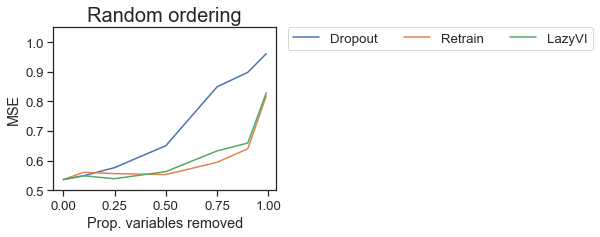

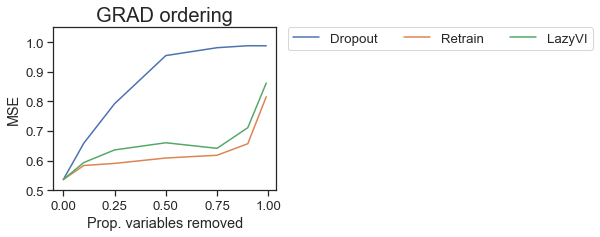

In [65]:
df = pd.DataFrame(results, columns=['pct_missing', 'ordering', 'method', 'time', 'mse'])
method_map = {
    'dropout':'Dropout',
    'lazy':'LazyVI',
    'retrain':'Retrain'
}

order_map = {
    'random':'Random',
    'ig':'Integrated Gradients',
    'gb':'Guided Backprop',
    'sal': 'GRAD'
}
df['method'] = df.method.map(method_map)
df['ordering'] = df.ordering.map(order_map)

#for method in ['Dropout', 'Retrain', 'LazyVI']:
for ordering in ['Random', 'GRAD']:
    plt.figure(figsize=(4,3))
    g = sns.lineplot(x='pct_missing', y='mse', hue='method', data=df[df.ordering==ordering], ci=None)
    plt.ylim(0.5,1.05)
    plt.ylabel('MSE')
    plt.xlabel('Prop. variables removed')
    g.legend_.set_title(None)
    plt.legend(bbox_to_anchor=(1.05, 1.), loc=2, ncol=3, borderaxespad=0.)
    plt.title(f"{ordering} ordering", fontsize=20)
    plt.show()

In [109]:
igidk = fts.pivot_table(index='lat', columns='lonnew', values='bigvi').sort_index(ascending=False).values

(-0.5, 19.5, 12.5, -0.5)

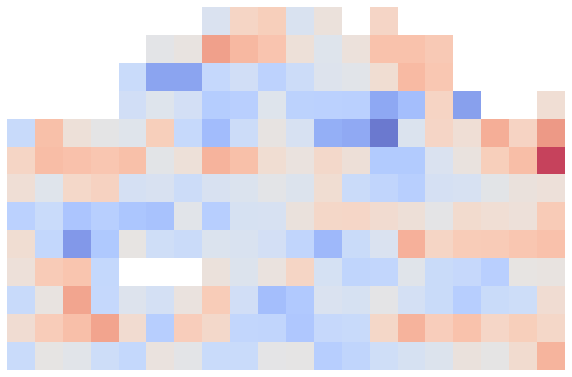

In [147]:
plt.figure(figsize=(10,8))
plt.imshow(igidk, cmap='coolwarm', alpha=.75)
plt.axis('off')


(-100.0, 100.0)

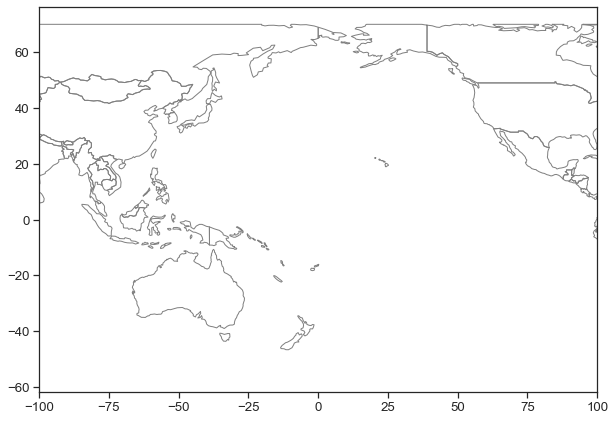

In [143]:

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world2 = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")].copy(deep=True)
world2.reset_index(inplace=True)

polys1 = gpd.GeoSeries([Polygon([(-180,-70), (0,-70), (0,70), (-180,70)])])
clipper1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1]})
polys2 = gpd.GeoSeries([Polygon([(0,-70), (180,-70), (180,70), (0,70)])])
clipper2 = gpd.GeoDataFrame({'geometry': polys2, 'df1':[1]})

# clip part 1 and part 2
pt1_df = gpd.overlay(clipper1, world2, how='intersection')
pt2_df = gpd.overlay(clipper2, world2, how='intersection')


# create a GeoSeries from each GeoDataFrame
wgs1 = gpd.GeoSeries([g for  g in pt1_df['geometry']])
wgs2 = gpd.GeoSeries([g for  g in pt2_df['geometry']])
# left hand side wraps around to rhs
gs1 = wgs1.translate(xoff=180)
# move rhs leftwards
gs2 = wgs2.translate(xoff=-180)

pt1_df['geometry'] = gs1 
pt2_df['geometry'] = gs2

both = pd.concat([pt1_df, pt2_df])
ax = both.boundary.plot(edgecolor='grey', linewidth=1, alpha=1, figsize=(10,8))
ax.set_xlim(-100, 100)
#ax.set_ylim(0, 120)
#plt.imshow(scipy.ndimage.zoom(igidk, 10, order=0), alpha=.5, cmap='coolwarm')